In [7]:
import os
import numpy as np
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 1) Load the .mat file
import os
mat_file =  "/home/saugat/Codelinux/Data/Botnet_Detection.mat"
if not os.path.exists(mat_file):
    print("File not found! Check the path.")
else:
    import scipy.io as sio
    data = sio.loadmat(mat_file)
    print("File loaded successfully!")

# 2) Print keys for sanity check
print("Keys in the dataset:")
for key in data.keys():
    if not key.startswith("__"):
        print(key, data[key].shape)




File loaded successfully!
Keys in the dataset:
camera_motion (7500, 1214)
camera_streaming (7500, 1356)
extrusion (7500, 2816)
idle (7500, 2490)
masuta_when_idle (7500, 1165)
masuta_with_camera (7500, 1157)
mirai_extrusion (7500, 2200)
mirai_idle (7500, 1534)
mirai_loader (7500, 792)
mirai_with_camera (7500, 910)
mirai_with_router (7500, 782)
mirai_with_voice (7500, 1018)
reboot (7500, 2288)
router (7500, 2469)
router_ftp (7500, 640)
voice_assistant (7500, 2391)


In [8]:
print("Keys in the .mat file:")
print(data.keys())

# Inspect each key's content if it is an array
for key in data.keys():
    # Skip the default keys added by MATLAB (those that start with '__')
    if key.startswith('__'):
        continue
    value = data[key]
    print(f"\nKey: {key}")
    print("Type:", type(value))
    print("Shape:", value.shape)
    print("Sample data (first 5 elements):")
    print(value.flat[:5])


Keys in the .mat file:
dict_keys(['__header__', '__version__', '__globals__', 'camera_motion', 'camera_streaming', 'extrusion', 'idle', 'masuta_when_idle', 'masuta_with_camera', 'mirai_extrusion', 'mirai_idle', 'mirai_loader', 'mirai_with_camera', 'mirai_with_router', 'mirai_with_voice', 'reboot', 'router', 'router_ftp', 'voice_assistant'])

Key: camera_motion
Type: <class 'numpy.ndarray'>
Shape: (7500, 1214)
Sample data (first 5 elements):
[2322.7996 1848.4739 2593.0518 2375.6792 2351.3965]

Key: camera_streaming
Type: <class 'numpy.ndarray'>
Shape: (7500, 1356)
Sample data (first 5 elements):
[1807.5135 2295.408  1946.121  2071.1233 2178.4712]

Key: extrusion
Type: <class 'numpy.ndarray'>
Shape: (7500, 2816)
Sample data (first 5 elements):
[1754.3162 1723.2656 2209.8035 1734.2009 1589.625 ]

Key: idle
Type: <class 'numpy.ndarray'>
Shape: (7500, 2490)
Sample data (first 5 elements):
[2186.7891 2015.361  1580.1116 1746.7391 1872.7076]

Key: masuta_when_idle
Type: <class 'numpy.ndarray'

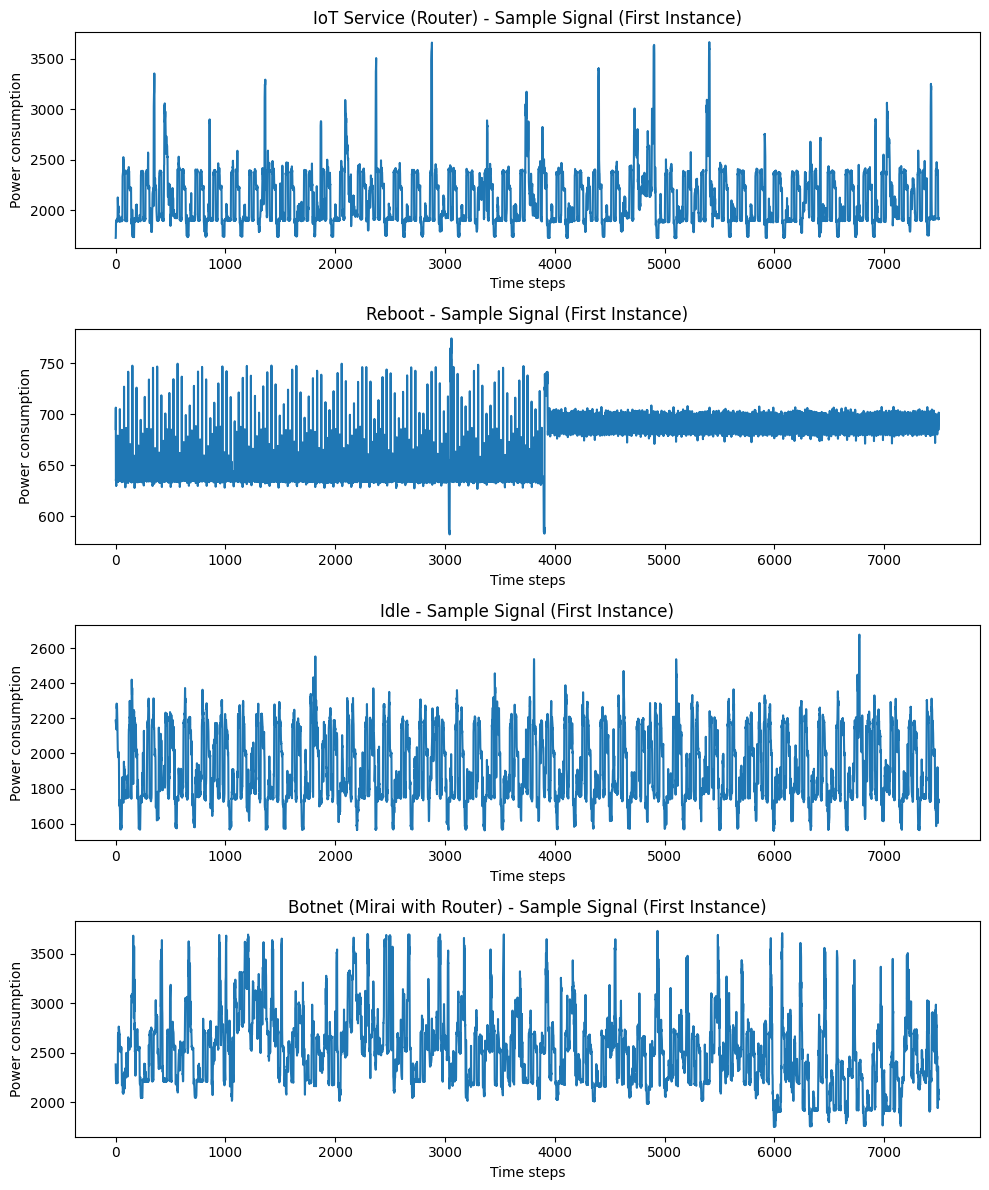

In [9]:
import matplotlib.pyplot as plt

# List of keys to visualize and their friendly names
keys_to_plot = {
    'router': 'IoT Service (Router)',
    'reboot': 'Reboot',
    'idle': 'Idle',
    'mirai_with_router': 'Botnet (Mirai with Router)'
}

fig, axes = plt.subplots(len(keys_to_plot), 1, figsize=(10, 3*len(keys_to_plot)))
if len(keys_to_plot) == 1:
    axes = [axes]  # ensure axes is iterable

for ax, (key, title) in zip(axes, keys_to_plot.items()):
    if key not in data:
        continue
    # data[key] shape is (7500, num_instances), so take first instance
    signal = data[key][:, 0]  # first instance
    ax.plot(signal)
    ax.set_title(f"{title} - Sample Signal (First Instance)")
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Power consumption")
plt.tight_layout()
plt.show()


In [10]:
import torch
from torch.utils.data import Dataset

class CombinedBotnetDataset(Dataset):
    def __init__(self, mat_file, mapping, transform=None):
        """
        Args:
            mat_file (str): Path to the .mat file.
            mapping (dict): Dictionary mapping key names to label integers.
                            For example: {'router': 0, 'reboot': 1, 'idle': 2, 'mirai_with_router': 3}
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Load the MATLAB file
        mat_data = sio.loadmat(mat_file)
        self.data_list = []
        self.labels_list = []
        self.transform = transform
        
        # Loop over each key and label in the mapping
        for key, label in mapping.items():
            if key not in mat_data:
                raise KeyError(f"Key '{key}' not found in the .mat file. Available keys: {mat_data.keys()}")
            # Each key is assumed to have shape (7500, num_instances)
            data_array = mat_data[key]
            # Transpose so that each instance is a row: shape becomes (num_instances, 7500)
            data_array = data_array.T
            self.data_list.append(data_array)
            # Create a label array with the same number of instances
            self.labels_list.append(np.full((data_array.shape[0],), label))
        
        # Concatenate data and labels from all classes
        self.X = np.concatenate(self.data_list, axis=0)  # shape: (total_instances, 7500)
        self.Y = np.concatenate(self.labels_list, axis=0)  # shape: (total_instances,)
        
        # Add a channel dimension for 1D CNN input (expected shape: (instances, channels, length))
        self.X = np.expand_dims(self.X, axis=1)
        
        # Normalize each instance to have zero mean and unit variance
        self.X = (self.X - self.X.mean(axis=-1, keepdims=True)) / (self.X.std(axis=-1, keepdims=True) + 1e-8)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = torch.tensor(self.X[idx], dtype=torch.float32)
        label = torch.tensor(self.Y[idx], dtype=torch.long)
        if self.transform:
            sample = self.transform(sample)
        return sample, label

# Define mapping: key in .mat file -> label
mapping = {
    'router': 0,            # IoT service
    'reboot': 1,            # Reboot
    'idle': 2,              # Idle
    'mirai_with_router': 3  # Botnet (Mirai)
}

# Create dataset and inspect a few samples
dataset = CombinedBotnetDataset(mat_file, mapping)
print("Total dataset size:", len(dataset))
sample0, label0 = dataset[0]
print("Sample 0 shape:", sample0.shape)  # Expecting (1, 7500)
print("Sample 0 label:", label0)


Total dataset size: 8029
Sample 0 shape: torch.Size([1, 7500])
Sample 0 label: tensor(0)


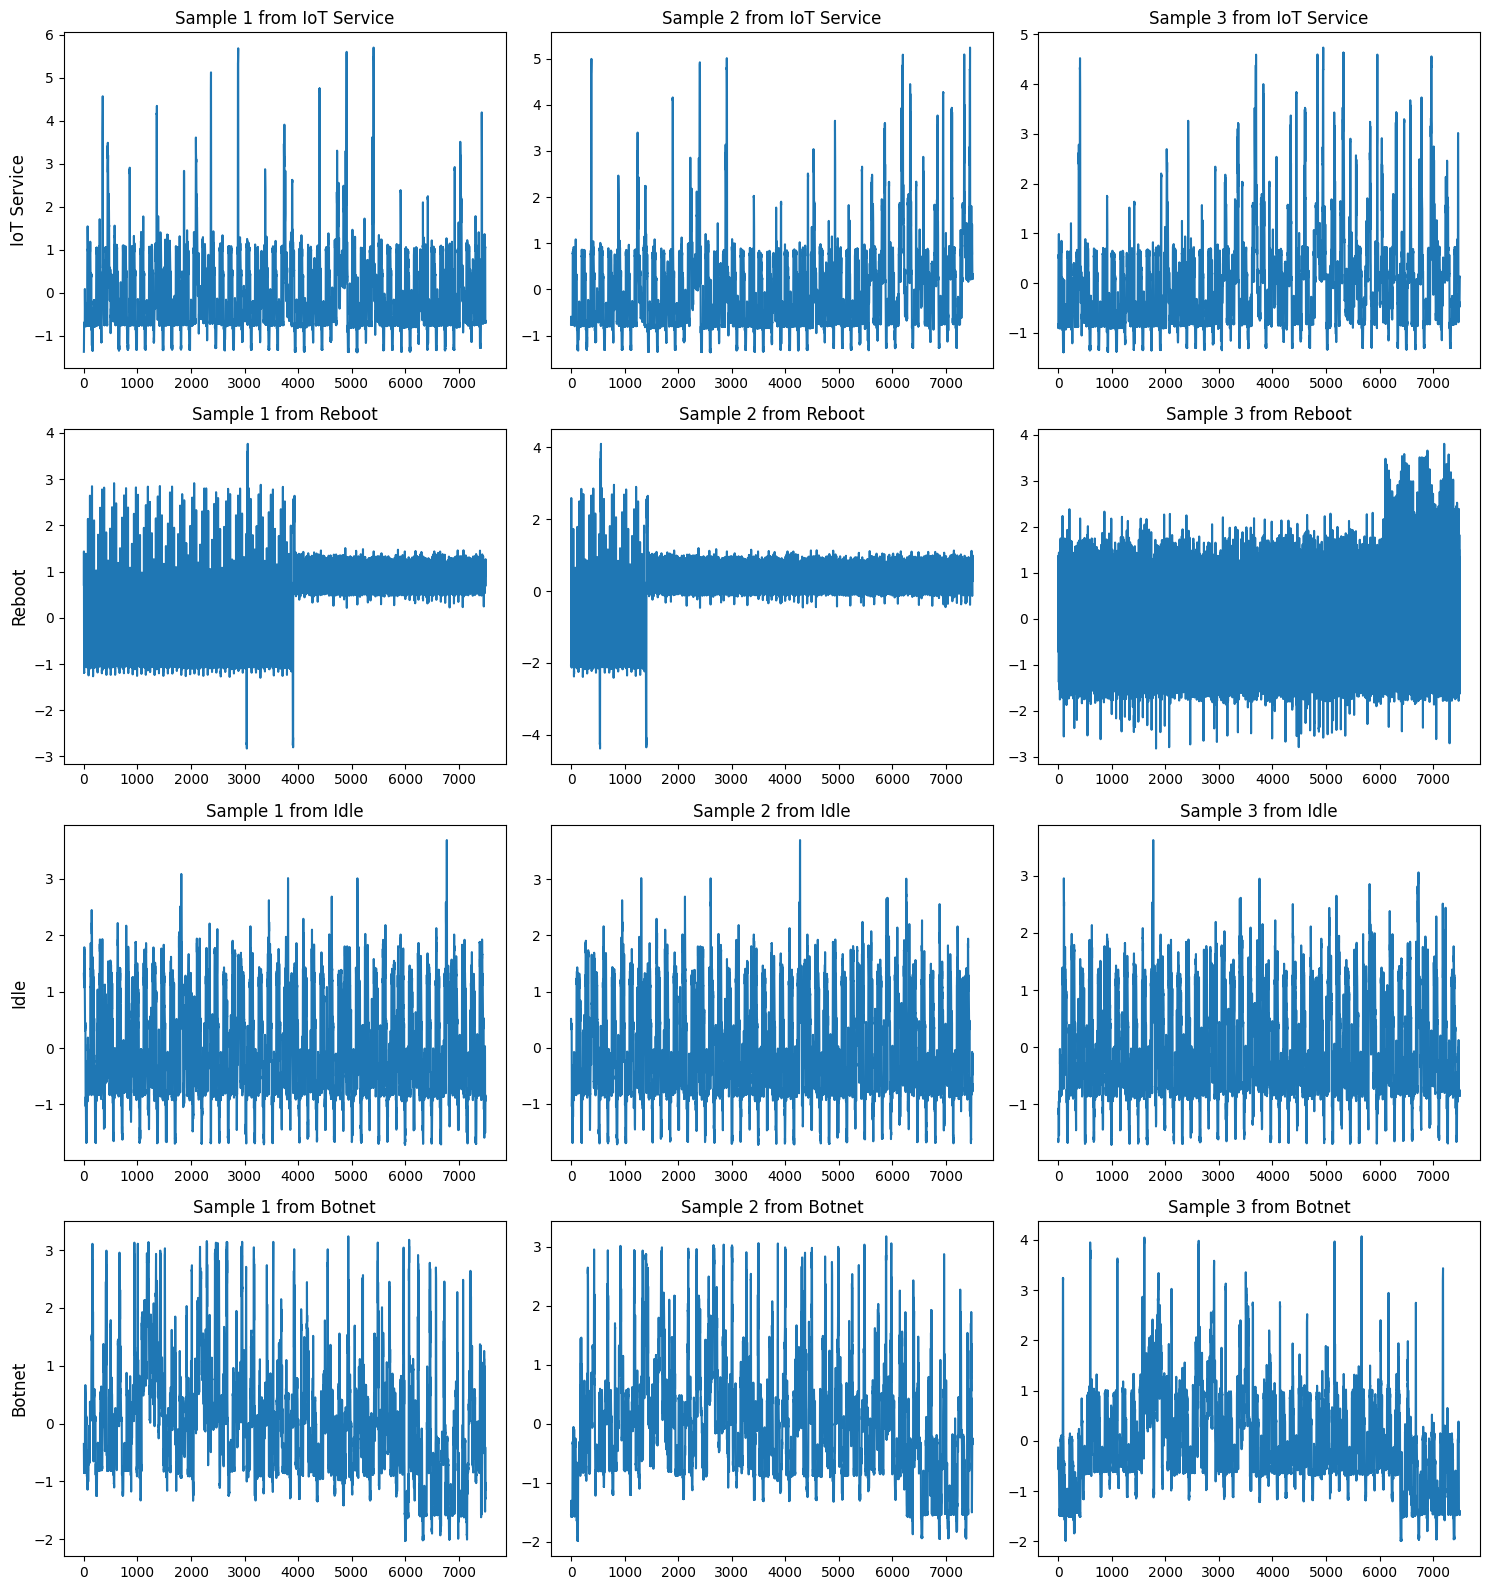

In [11]:
# For each class label, plot a few sample signals from the combined dataset
class_names = ['IoT Service', 'Reboot', 'Idle', 'Botnet']
samples_per_class = 3

fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(15, 4*len(class_names)))
for cls in range(len(class_names)):
    # Find indices corresponding to the class
    indices = np.where(dataset.Y == cls)[0]
    # Select a few samples
    for j in range(samples_per_class):
        if j >= len(indices):
            break
        sample, _ = dataset[indices[j]]
        # sample shape is (1, 7500), squeeze to (7500,)
        axes[cls, j].plot(sample.squeeze().cpu().numpy())
        if j == 0:
            axes[cls, j].set_ylabel(class_names[cls], fontsize=12)
        axes[cls, j].set_title(f"Sample {j+1} from {class_names[cls]}")
plt.tight_layout()
plt.show()


In [12]:
from torch.utils.data import random_split

# Get the total dataset size
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Total samples: 8029
Training samples: 5620
Validation samples: 1204
Test samples: 1205


In [13]:
# Function to count labels in a dataset
def count_labels(subset):
    labels = [label.item() for _, label in subset]
    counts = np.bincount(labels, minlength=len(class_names))
    return counts

train_counts = count_labels(train_dataset)
val_counts = count_labels(val_dataset)
test_counts = count_labels(test_dataset)

print("Label distribution in Training set:", dict(zip(class_names, train_counts)))
print("Label distribution in Validation set:", dict(zip(class_names, val_counts)))
print("Label distribution in Test set:", dict(zip(class_names, test_counts)))


Label distribution in Training set: {'IoT Service': np.int64(1698), 'Reboot': np.int64(1578), 'Idle': np.int64(1772), 'Botnet': np.int64(572)}
Label distribution in Validation set: {'IoT Service': np.int64(374), 'Reboot': np.int64(370), 'Idle': np.int64(356), 'Botnet': np.int64(104)}
Label distribution in Test set: {'IoT Service': np.int64(397), 'Reboot': np.int64(340), 'Idle': np.int64(362), 'Botnet': np.int64(106)}


In [15]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created.")



DataLoaders created.


In [17]:
import torch.optim as optim
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

print(rf_model)

RandomForestClassifier(max_depth=10, random_state=42)


In [19]:
def fit_rf(model, train_loader):
    X_train, y_train = [], []
    
    # Collect all data from the DataLoader (convert to NumPy)
    for batch in train_loader:
        inputs, labels = batch  # Shape: (batch_size, channels, features)
        
        # Convert tensors to NumPy and flatten (batch_size, channels * features)
        X_train.append(inputs.numpy().reshape(inputs.shape[0], -1))  
        y_train.append(labels.numpy())

    # Stack all batches into a single dataset
    X_train = np.vstack(X_train)  # Shape: (num_samples, num_features)
    y_train = np.hstack(y_train)  # Shape: (num_samples,)

    # Train Random Forest
    model.fit(X_train, y_train)
    print("Random Forest training completed.")

fit_rf(rf_model, train_loader)



Random Forest training completed.


In [20]:
from sklearn.metrics import accuracy_score

def validate_rf(model, val_loader):
    X_val, y_val = [], []
    
    # Collect all validation data from the DataLoader (convert to NumPy)
    for batch in val_loader:
        inputs, labels = batch  # Shape: (batch_size, channels, features)
        
        # Convert tensors to NumPy and flatten (batch_size, channels * features)
        X_val.append(inputs.numpy().reshape(inputs.shape[0], -1))
        y_val.append(labels.numpy())

    # Stack all batches into a single dataset
    X_val = np.vstack(X_val)  # Shape: (num_samples, num_features)
    y_val = np.hstack(y_val)  # Shape: (num_samples,)

    # Make predictions
    y_pred = model.predict(X_val)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy:.4f}")

validate_rf(rf_model, val_loader)


Validation Accuracy: 0.8829


In [22]:



X_train, y_train = [], []
    
    # Collect all data from the DataLoader (convert to NumPy)
for batch in train_loader:
    inputs, labels = batch  # Shape: (batch_size, channels, features)
        
        # Convert tensors to NumPy and flatten (batch_size, channels * features)
    X_train.append(inputs.numpy().reshape(inputs.shape[0], -1))  
    y_train.append(labels.numpy())

    # Stack all batches into a single dataset
X_train = np.vstack(X_train)  # Shape: (num_samples, num_features)
y_train = np.hstack(y_train)  # Shape: (num_samples





from sklearn.metrics import accuracy_score


X_val, y_val = [], []
    
    # Collect all validation data from the DataLoader (convert to NumPy)
for batch in val_loader:
    inputs, labels = batch  # Shape: (batch_size, channels, features)
        
        # Convert tensors to NumPy and flatten (batch_size, channels * features)
    X_val.append(inputs.numpy().reshape(inputs.shape[0], -1))
    y_val.append(labels.numpy())

    # Stack all batches into a single dataset
X_val = np.vstack(X_val)  # Shape: (num_samples, num_features)
y_val = np.hstack(y_val)  # Shape: (num_samples,)



train_acc = []
val_acc = []
n_trees = list(range(1, 201, 10))  # Testing different numbers of trees

for n in n_trees:
    model = RandomForestClassifier(n_estimators=n, max_depth=10, random_state=42)
    model.fit(X_train, y_train)

    # Compute accuracy
    train_acc.append(accuracy_score(y_train, model.predict(X_train)))
    val_acc.append(accuracy_score(y_val, model.predict(X_val)))

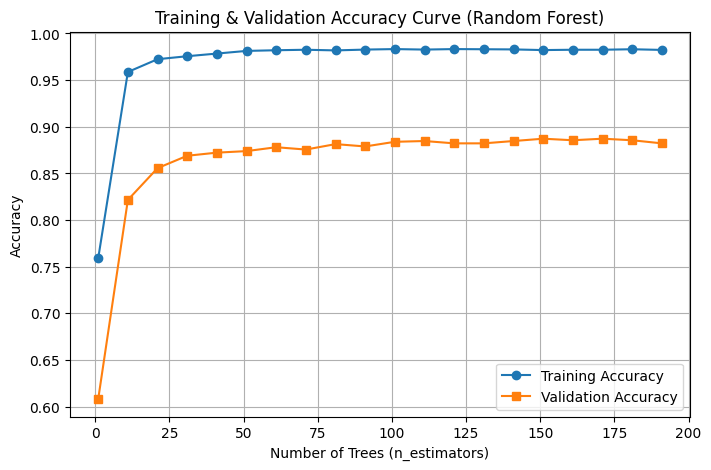

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(n_trees, train_acc, label="Training Accuracy", marker="o")
plt.plot(n_trees, val_acc, label="Validation Accuracy", marker="s")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Curve (Random Forest)")
plt.legend()
plt.grid()
plt.show()

In [27]:
print(max(train_acc))
print(max(val_acc))

0.9830960854092526
0.8870431893687708


In [31]:
print(train_acc[-1])
print(val_acc[-1])

0.9822064056939501
0.8820598006644518


In [ ]:
'''test'''